In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2025-03-03 09:01:47.637809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 09:01:47.645657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 09:01:47.661418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740992507.692562    6003 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740992507.701027    6003 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 09:01:47.731222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
tsla = pd.read_csv("../data/TSLA_cleaned.csv", parse_dates=True, index_col="Date")
bnd = pd.read_csv("../data/BND_cleaned.csv", parse_dates=True, index_col="Date")
spy = pd.read_csv("../data/SPY_cleaned.csv", parse_dates=True, index_col="Date")

In [5]:
tsla.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02 05:00:00+00:00,0.011513,0.009519,0.010743,0.010723,0.067348
2015-01-05 05:00:00+00:00,0.010324,0.008578,0.009835,0.009416,0.077377
2015-01-06 05:00:00+00:00,0.009682,0.008257,0.009397,0.009584,0.092210
2015-01-07 05:00:00+00:00,0.010153,0.008338,0.010225,0.009538,0.037529
2015-01-08 05:00:00+00:00,0.010075,0.008201,0.010259,0.009491,0.045400


In [17]:
# Split into train (80%) and test (20%)
train_size = int(len(tsla) * 0.8)
train, test = tsla['Close'][:train_size], tsla['Close'][train_size:]

In [18]:
# Train ARIMA Model
order = (5, 1, 0)
model = ARIMA(train, order=order)
model_fit = model.fit()

/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [19]:
# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/user/Time-Series-Forecasting-for-Portfolio-Management-Optimization/.env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


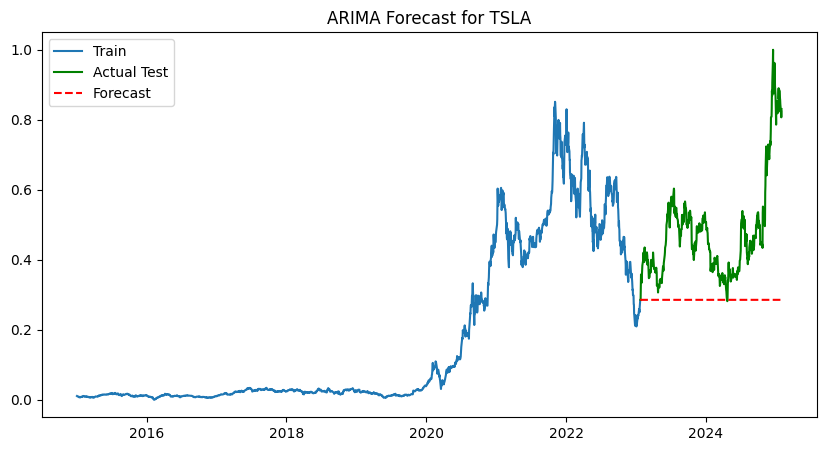

In [20]:
# Plot results
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual Test", color='green')
plt.plot(test.index, forecast, label="Forecast", color='red', linestyle="dashed")
plt.legend()
plt.title(f"ARIMA Forecast for TSLA")
plt.show()

In [21]:
# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2028
Model:                 ARIMA(5, 1, 0)   Log Likelihood                6137.919
Date:                Mon, 03 Mar 2025   AIC                         -12263.838
Time:                        09:42:10   BIC                         -12230.152
Sample:                             0   HQIC                        -12251.478
                               - 2028                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0376      0.012     -3.108      0.002      -0.061      -0.014
ar.L2          0.0154      0.010      1.498      0.134      -0.005       0.036
ar.L3      -1.843e-05      0.013     -0.001      0.9